In [26]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [3]:
# def load_dataset():
#     '''
#     loads dataset, from wavefunctions.txt and potential.txt
#     '''
#     with open('potential.txt','r') as f:
#         potential = np.loadtxt(f,delimiter=', ')
# #         print(np.shape(potential))
#     with open('wavefunctions.txt','r') as f:
#         wavefunctions = np.loadtxt(f,delimiter=', ')
# #         print(np.shape(wavefunctions))
    
#     return potential.T, wavefunctions.T
    
    
# X, Y  = load_dataset()

In [16]:
def load_dataset(filename):
    '''
    loads dataset, from an hdf5 file
    
    Args: 
        filename: name of hdf5 file (including extension) to load
        
    Returns:
        potential, wavefunction, and energy arrays 
    '''    
    with h5py.File(filename,'r') as f:
        potential = np.array(f['pot_data'])
        wavefunctions = np.array(f['psi_data'])
        energy = np.array(f['en_data'])
        
    return potential.T, wavefunctions.T, energy.T
    


In [6]:
print(np.shape(X))

(1000, 500)


In [7]:
print(np.shape(Y))

(1000, 500)


In [170]:
X_tot, Y_tot, energy_tot  = load_dataset('schro_data.hdf5') # we pull up all the X and Y data we have. Note that is is unshuffled.
m_tot = np.shape(X_tot)[1]
X_train = X_tot[:, : 800] # we take the first 800 examples of X_tot as training data
X_test = X_tot[:,800 :] # we take the last 200 examples of X_tot as test data
Y_train = Y_tot[:,: 800] # same idea with Y labels
Y_test = Y_tot[:,800 :]
assert np.shape(X_train)[1] == np.shape(Y_train)[1]
m_train = np.shape(X_train)[1]
m_test = np.shape(Y_train)[1]

# Now, we have 100 examples of training data (X_train,Y_train) and 50 examples of test data (X_test,Y_test)! 

In [171]:
def initialize_parameters(n_x,n_y): # this is where we decide the NN architecture. Let's take n_x as an argument, since our first layer weights need to deal with that. Same idea with n_y
    parameters = {'W1':None,'b1':None,'W2':None,'b2':None,'W3':None,'b3':None}
    # randomly initializing parameters to be in Gaussian distribution, with mean 0 and variance 1
    parameters['W1'] = np.random.randn(5,n_x)*np.sqrt(2/(n_x)) # actually initializing w He initialization
    parameters['b1'] = np.random.randn(5,1)*np.sqrt(2/(n_x))
    parameters['W2'] = np.random.randn(6,5)*np.sqrt(2/(5))
    parameters['b2'] = np.random.randn(6,1)*np.sqrt(2/(5))
    parameters['W3'] = np.random.randn(n_y,6)*np.sqrt(2/(6))
    parameters['b3'] = np.random.randn(n_y,1)*np.sqrt(2/(6))
    return parameters

def initialize_gradients(parameters):
    gradients={
        'dW1':None,
        'db1':None,
        'dW2':None,
        'db2':None,
        'dW3':None,
        'db3':None
    }
    gradients['dW1'] = np.zeros(np.shape(parameters['W1']))
    gradients['db1'] = np.zeros(np.shape(parameters['b1']))
    gradients['dW2'] = np.zeros(np.shape(parameters['W2']))
    gradients['db2'] = np.zeros(np.shape(parameters['b2']))
    gradients['dW3'] = np.zeros(np.shape(parameters['W3']))
    gradients['db3'] = np.zeros(np.shape(parameters['b3']))
    return gradients

In [172]:
def softmax(ZL): # inputs the vector Z of the final layer
    denom = np.sum((np.exp(ZL-np.max(ZL))),axis=0) # subtract max(x) to shrink values & avoid exploding gradient
#     print('denom:',denom)
    return np.divide((np.exp(ZL-np.max(ZL))),denom)
def sigmoid(ZL): # NOTE: decided to go w relu on all just bc it's easier to do derivatives
    return 1/(1+np.exp(-ZL))
def relu(ZL):
    return ZL.clip(min=0) # clips all negative elements of ZL, setting them to 0
def relu_back(AL): # computes derivative of relu fn, given the layer's activation
    mask = np.zeros(np.shape(AL))
    mask[AL>0]=1 # NOTE: technically, should be 1 or 0 based on ZL, not AL. But since AL = 0 iff ZL <= 0, this still works as shorthand
    mask[AL<=0]=0
#     print('AL is: ' +str(AL))
#     print('mask is: '+str(mask))
    return mask # return original value of AL if entry was nonnegative; 0 if negative

In [173]:
def forward_prop(X,Y,parameters,lambd=0): # given a set of parameters and our data, let's pass it forward and see what our guesses are.
    m = np.shape(X)[1]
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    

    Z1 = np.dot(W1,X)+b1
    A1 = relu(Z1)
    # W2: 6 x 5
    # A1: 5 x 50
    Z2 = np.dot(W2,A1)+b2
    A2 = relu(Z2)

    Z3 = np.dot(W3,A2)+b3 
    A3 = Z3 # was softmax

    assert np.shape(A3) == np.shape(Y)

    
#     cost = 1/m*(np.sum(np.multiply(Y,-np.log(A3))) + 0.5*lambd*(np.sum(W3**2)+np.sum(W2**2)+np.sum(W1**2)))# let's do the cross entropy loss
    
    cost = 1/m*(np.sum(np.multiply(Y,-(A3))) + 0.5*lambd*(np.sum(W3**2)+np.sum(W2**2)+np.sum(W1**2)))# let's do the cross entropy loss

    
    cache = (Z1,Z2,Z3,X,A1,A2,lambd) # saving these babies for later
    
    return A3,cache,cost

In [174]:
def back_prop(A3,Y,cache, parameters,gradients,debug=False):    # Note: A3, Y, and cache can be of however many examples we happen to want to input at once
    (Z1,Z2,Z3,X,A1,A2,lambd) = cache
    m = np.shape(X)[1]
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # dZ3: 1000 x 50
    # A2: 5 x 50
    # A2.T: 50 x 5
    # np.dot(dZ3,A2.T): 1000 x 5
    dZ3 = A3-Y # someone calculated this here: https://deepnotes.io/softmax-crossentropy
#     dZ3 = np.ones(np.shape(A3))
    dW3 = 1/m*(np.dot(dZ3,A2.T) + lambd*np.sum(abs(W3)))
    db3 = 1/m*np.sum(dZ3,axis=1,keepdims=True) # so we don't get any rank 1 arrays

    if debug:
        print('Layer 3 Backprop:')
#         print('dA3 = '+str(np.average(dA3)))
        print('dZ3 = '+str(np.average(dZ3)))
        print('dW3 = '+str(np.average(dW3)))
        print('db3 = '+str(np.average(db3)))
        print('~'*30)
    
    dA2 = np.dot(W3.T,dZ3) # basically running fwd prop but in reverse! using W3.T to get from dZ3 to A2, instead of the other way around! :D
    dZ2 = np.multiply(dA2,relu_back(A2)) # derivative of the relu fn
    dW2 = 1/m*(np.dot(dZ2,A1.T) + lambd*np.sum(abs(W2)))# include regulaization term
    db2 = 1/m*np.sum(dZ2,axis=1,keepdims=True)
    
    if debug:
        print('Layer 2 Backprop:')
#         print('dA2 = '+str(np.average(dA2)))
        print('dZ2 = '+str(np.average(dZ2)))
        print('dW2 = '+str(np.average(dW2)))
        print('db2 = '+str(np.average(db2)))
        print('~'*30)
    
    dA1 = np.dot(W2.T,dZ2)
    dZ1 = np.multiply(dA1,relu_back(A1))
    dW1 = 1/m*(np.dot(dZ1,X.T) + lambd*np.sum(abs(W1)))
    db1 = 1/m*np.sum(dZ1,axis=1,keepdims=True)
    
    if debug:
        print('Layer 1 Backprop:')
#         print('dA1 = '+str(np.average(dA1)))
        print('dZ1 = '+str(np.average(dZ1)))
        print('dW1 = '+str(np.average(dW1)))
        print('db1 = '+str(np.average(db1)))
        print('~'*30)
    
    assert (np.shape(W1)==np.shape(dW1))
    assert (np.shape(b1)==np.shape(db1))
    assert (np.shape(W2)==np.shape(dW2))
    assert (np.shape(b2)==np.shape(db2))
    assert (np.shape(W3)==np.shape(dW3))
    assert (np.shape(b3)==np.shape(db3))
    
    
    gradients['dW1'] = dW1
    gradients['db1'] = db1
    gradients['dW2'] = dW2
    gradients['db2'] = db2
    gradients['dW3'] = dW3
    gradients['db3'] = db3
    
    
    return gradients

In [175]:
def update_parameters(parameters,gradients,learning_rate=0.005,clip=False):
    if clip:
        parameters['W1'] = parameters['W1'] - learning_rate*np.clip(gradients['dW1'],-5,5)
        parameters['b1'] = parameters['b1'] - learning_rate*np.clip(gradients['db1'],-5,5)
        parameters['W2'] = parameters['W2'] - learning_rate*np.clip(gradients['dW2'],-5,5)
        parameters['b2'] = parameters['b2'] - learning_rate*np.clip(gradients['db2'],-5,5)
        parameters['W3'] = parameters['W3'] - learning_rate*np.clip(gradients['dW3'],-5,5)
        parameters['b3'] = parameters['b3'] - learning_rate*np.clip(gradients['db3'],-5,5)  
    else:
        parameters['W1'] = parameters['W1'] - learning_rate*gradients['dW1']
        parameters['b1'] = parameters['b1'] - learning_rate*gradients['db1']
        parameters['W2'] = parameters['W2'] - learning_rate*gradients['dW2']
        parameters['b2'] = parameters['b2'] - learning_rate*gradients['db2']
        parameters['W3'] = parameters['W3'] - learning_rate*gradients['dW3']
        parameters['b3'] = parameters['b3'] - learning_rate*gradients['db3']
    return parameters

In [176]:
def plot_cost(costs,validation_costs=None):
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    if validation_costs!=None:
        plt.plot(validation_costs)
        plt.legend(('Training Error','Validation Error'))
    else:
        plt.legend(('Training Error'))
    plt.show()

In [177]:
def train_model(X,Y,
                X_test=None,
                Y_test=None,
                epochs=10,
          show_epochs=True,
          lambd=0.5,
          starting_parameters=None,
          clip_grads=False,
          debug_backprop=False,
          plot_costs=False,
          learning_rate=0.005
         ):
    
    n_x = np.shape(X)[0]
    n_y = np.shape(Y)[0]
    
    if starting_parameters == None:
        parameters = initialize_parameters(n_x,n_y)
    else:
        parameters = starting_parameters
#     print('initial param = '+str(parameters['W3'][1,1]))
    gradients = initialize_gradients(parameters)
    
    costs=[]
    
    validation_costs=[]
    
    for ep in range(epochs):
        A3,cache,cost = forward_prop(X,Y,parameters,lambd=lambd)
        if X_test.all()!=None and Y_test.all()!=None:
            _,_,val_cost = forward_prop(X_test,Y_test,parameters,lambd=lambd)
            validation_costs.append(val_cost)
        gradients = back_prop(A3,Y,cache,parameters,gradients,debug=debug_backprop)
        parameters = update_parameters(parameters,gradients,clip=clip_grads,learning_rate=learning_rate)
        costs.append(cost)
        
        if show_epochs:
            print('Epoch '+str(ep) +':')
            print('cost = '+str(cost))
#             if clip_grads:
#                 print('grad = ' +str(np.clip(np.average(gradients['dW3']),-5,5)))
#             else:
#                 print('grad = ' +str(np.average(gradients['dW3'])))
#             print('param = '+str(np.average(parameters['W3'])))
            print('>'*50)

    if plot_costs:
        if X_test.all()!=None and Y_test.all()!=None:
            plot_cost(costs,validation_costs=validation_costs)
        else:
            plot_cost(costs)
            
    return parameters

In [214]:
def predict(X,Y,parameters,idx):
    '''
    X: potential data
    Y: numerov wavefunction data
    parameters: parameters to use
    idx: index of wavefunction to check out
    '''
#     print(np.shape(X))
    A3,_,cost = forward_prop(X,Y,parameters,lambd=0) # we only care about our predictions, A3!
#     indices = np.argmax(A3,axis=0) # returns index of greatest value in a particular prediction (column) of A3
#     pred = np.eye(3)[indices].T # converts indices to a one-hot vector! amazing!
    
#     total_guesses = np.shape(X)[1]
#     correct_guesses = np.sum(np.multiply(Y,pred)) # since Y and pred are both one-hot vectors, we can do elementwise multiplication. This will return 1 for matching columns, and 0 for non-matching ones. Summing these up will yield the number of correct guesses.
    
#     accuracy = correct_guesses/total_guesses
    print(np.shape(A3))
    plt.figure(figsize=(8,6))
    plt.plot(X[:,idx],label='Potential')
    plt.title('Potential')
    plt.show()
    plt.figure(figsize=(8,6))
    plt.plot(Y[:,idx],label='Numerov Wavefunction')
    plt.plot(A3[:,idx],label='ML Wavefunction')
    plt.title('Wavefunctions')
    plt.legend(loc='best')
    plt.show()
    
    
    
    for item in range(np.shape(X)[1]):
        plt.plot(Y[:,item])
    plt.title(f'All {np.shape(X)[1]} Numerov Wavefunctions')
    plt.show()
    
    avg_psi = np.average(Y,axis=1)
    plt.title(f'Averaged {np.shape(X)[1]} Numerov Wavefunctions')
    plt.plot(avg_psi)
    plt.show()
    
    for item in range(np.shape(X)[1]):
        plt.plot(A3[:,item])
    plt.title(f'All {np.shape(X)[1]} ML Wavefunctions')
    plt.show()
    
    return

# def single_predict(X,parameters,Y=np.zeros((3,1)),answer=None):
#     X = np.asarray(X)
#     Y = np.asarray(Y)
#     X = X.reshape(-1,1) # makes X and Y into column vectors
#     Y = Y.reshape(-1,1)
#     A3,_,cost = forward_prop(X,Y,parameters,lambd=0)
#     index = np.argmax(A3,axis=0) # returns index of greatest value in a particular prediction (column) of A3
#     print('The Neural Network says: ')
#     if index==0:
#         print('Hmmm... I think this is an Iris-setosa.')
#     elif index==1:
#         print('Why of course! This must be an Iris-versicolor!')
#     elif index==2:
#         print('This is none other than an Iris-virginica.')
#     else:
#         print('Something went wrong...')
#     print("* "*10)
#     if Y.all()!=None and answer==None:
#         if np.sum(Y*np.eye(3)[0].reshape(-1,1))==1:
#             print('The correct answer is Iris-setosa.')
#         elif np.sum(Y*np.eye(3)[1].reshape(-1,1))==1:
#             print('The correct answer is Iris-versicolor.')
#         elif np.sum(Y*np.eye(3)[2].reshape(-1,1))==1:
#             print('The correct answer is Iris-virginica.')
#     elif Y.all()==None and answer!=None:
#         print('The correct answer is '+str(answer))

In [204]:
# Now, let's put it all together!

parameters = train_model(
                    X_train[:,:],
                    Y_train[:,:],
                    X_test,
                    Y_test,
                    epochs=1000,
                    show_epochs=False,
                    clip_grads=False,
                    debug_backprop=False,
                    learning_rate = 0.01,
                  )
# print("Accuracy on training data: " + str(predict(X_test[:,:],Y_test[:,:],parameters)))
# print("Accuracy on test data: " + str(predict(X_train[:,:],Y_train[:,:],parameters)))

# predict(X=X_train,Y=Y_train,parameters=parameters,idx=7)

# print('~'*50)

(1000, 800)


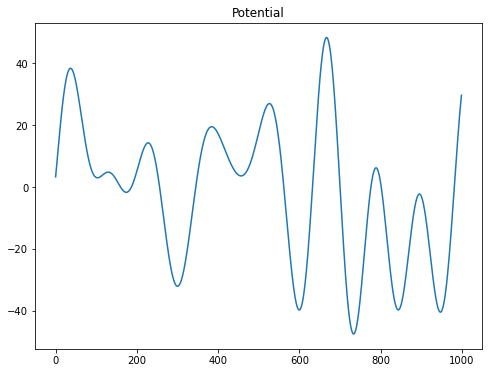

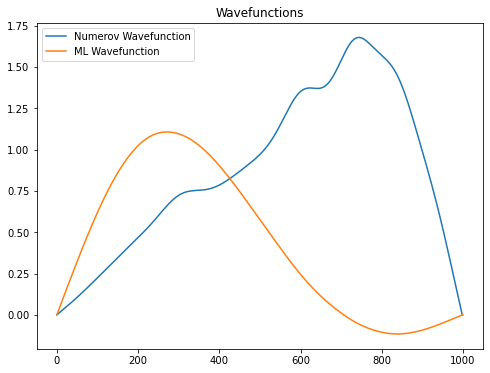

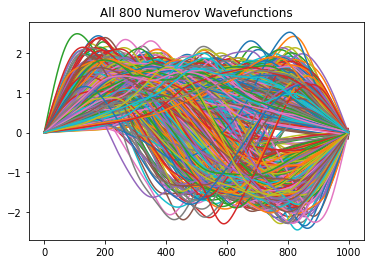

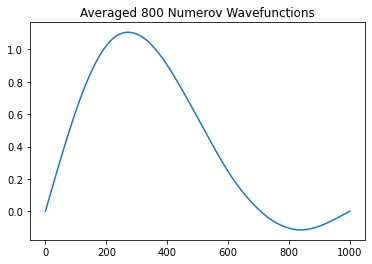

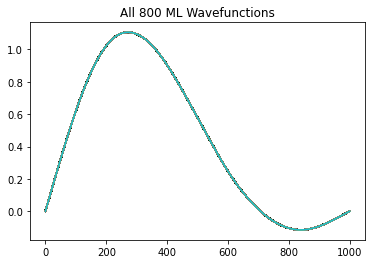

(1000, 200)


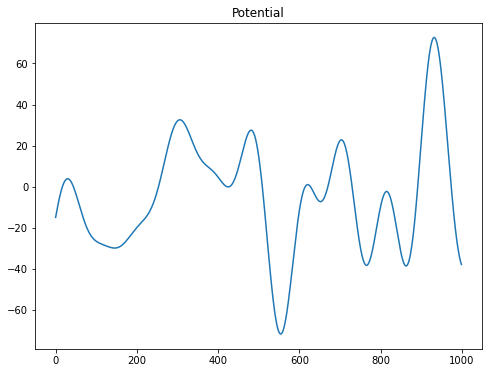

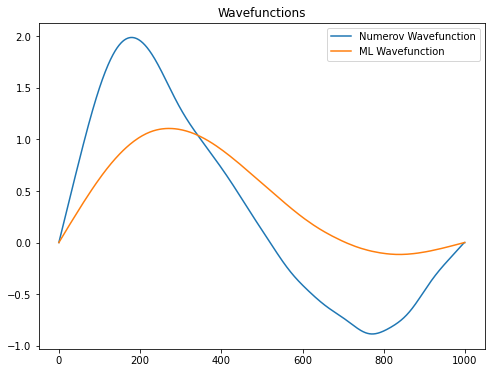

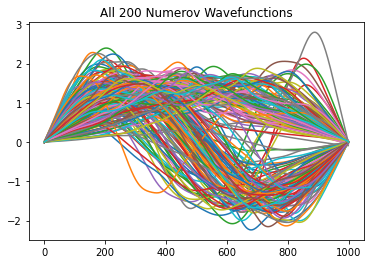

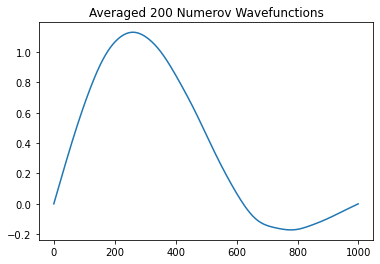

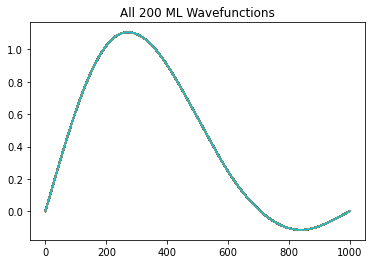

In [215]:
predict(X=X_train,Y=Y_train,parameters=parameters,idx=10)

predict(X=X_test,Y=Y_test,parameters=parameters,idx=10)

# print(parameters)

In [87]:
A = np.arange(0,4)
print(A)
A[A==0] = 10
print(A)

[0 1 2 3]
[10  1  2  3]
